# Анализ пользователей и маркетинга приложения Procrastinate Pro+

### Введение

#### Данные

В нашем распоряжении три датасета: лог сервера с информацией о посещениях сайта с 1.05.19 по 27.10.19 (visits_info_short.csv), информацией о заказах (orders_info_short.csv) и информацией о расходах на рекламу (costs_info_short.csv).

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя
- Region — страна пользователя
- Device — тип устройства пользователя
- Channel — идентификатор источника перехода
- Session Start — дата и время начала сессии
- Session End — дата и время окончания сессии

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя
- Event Dt — дата и время покупки
- Revenue — сумма заказа

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании
- Channel — идентификатор рекламного источника
- costs — расходы на эту кампанию

#### Шаги исследования

- Загрузим и изучим данные, выполним предобработку (обработаем пропуски и дубликаты, по необходимости изменим типы данных)
- Зададим функции, нужные для анализа и визуализации 
- Составим профили пользователей. Изучим, из каких стран приходят пользователи, какими устройствами пользуются
- Изучим рекламные источники привлечения. Посчитаем общую сумму расходов на маркетинг, выясним, как траты распределены по рекламным источникам, узнаем средний CAC для каждого источника
- Оценим окупаемость рекламы c помощью графиков LTV и ROI, а также динамики LTV, CAC и ROI
- Проверим конверсию и удержание пользователей и динамику их изменения

#### Цель исследования

Ответить на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

Описать возможные причины неэффективности привлечения пользователей и дать рекомендации для рекламного отдела.

### Общая информация

In [1]:
# Импортируем нужные библиотеки, загрузим данные и изучим общую информацию о них.

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

visits = pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_6_метрики\visits_info_short.csv") #журнал посещений сайта 
orders = pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_6_метрики\orders_info_short.csv") #инфо о покупках 
costs =  pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_6_метрики\costs_info_short.csv")  #затраты на рекламу

display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


В таблице 6 столбцов и 309901 строка, пропусков нет. Тип данных в столбцах Session Start и Session End нужно будет преобразовать в datetime.

In [2]:
display(orders.head())
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


В таблице 3 столбца и 40212 строк, пропусков нет. Тип данных в столбце Event Dt нужно будет преобразовать в datetime.

In [3]:
display(costs.head())
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В таблице 3 столбца и 1800 строк, пропусков нет. Тип данных в столбце dt нужно будет преобразовать в datetime.

### Функции

Зададим сразу все функции, которые понадобятся нам для исследования. Мы взяли функции из теоретической части курса, немного адаптировав их для нашего кейса.

Это функции для вычисления значений метрик:

- get_profiles() — для создания профилей пользователей,
- get_retention() — для подсчёта удержания,
- get_conversion() — для подсчёта конверсии,
- get_ltv() — для подсчёта LTV.

А также функции для построения графиков:

- filter_data() — для сглаживания данных,
- plot_retention() — для построения графика удержания,
- plot_conversion() — для построения графика конверсии,
- plot_ltv_roi — для визуализации LTV и ROI.

In [4]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [5]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [6]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [7]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Предобработка данных

In [12]:
#переименуем столбцы, приведя их к «змеиному регистру»

visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [13]:
#изменим тип данных в столбцах, где содержатся даты и время

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
#проверим, есть ли в таблицах дубликаты
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

Дубликатов в таблицах нет. Выше мы также выяснили, что пропусков тоже нет.
Предобработка завершена, можем приступать к анализу.

### Исследовательский анализ пользовательских профилей

Составим профили пользователей с помощью функции get_profiles

In [17]:
profiles = get_profiles(visits, orders, costs) #создаем таблицу с профилями

display(profiles.head()) #выводим на экран первые 5 строк новой таблицы

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


По условиям задания, сегодня - 1 ноября 2019 года; у нас есть данные о пользователях, привлеченных с 1.05.19 по 27.10.19; а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Значит, горизонт анализа - 14 дней, минимальная дата привлечения пользователей - 1.05.19, максимальная - 14.10.19.

In [18]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

min_date = datetime(2019, 5, 1).date()
max_date = datetime(2019, 10, 14).date()

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
all_country_profiles = profiles.pivot_table(index='region', values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending=False)
paying_country_profiles = profiles.loc[profiles['payer']==True].pivot_table(index='region', values='user_id', aggfunc='nunique')
country_profiles = all_country_profiles.merge(paying_country_profiles, on='region')
country_profiles.columns = ['all_users', 'paying_users']
country_profiles['paying_share'] = country_profiles['paying_users']/country_profiles['all_users']*100

country_profiles

,all_users,paying_users,paying_share
region,,,
United States,100002,6902,6.901862
UK,17575,700,3.982930
France,17450,663,3.799427
Germany,14981,616,4.111875


Как видно из таблицы, пользователи приложения пришли из 4х стран - США, Великобритании, Франции и Германии. Большинство - из США, сто тысяч человек, из Британии и Франции почти поровну, около 17,5 тысяч человек, на последнем месте Германия с почти 15 тысячами человек.

Доля платящих пользователей также выше всего у США, почти 7%, на втором месте Германия, чуть больше 4%, Британия и Франция опять почти поровну, чуть меньше 4%.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
all_devices_profiles = profiles.pivot_table(index='device', values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending=False)
paying_devices_profiles = profiles.loc[profiles['payer']==True].pivot_table(index='device', values='user_id', aggfunc='nunique')
devices_profiles = all_devices_profiles.merge(paying_devices_profiles, on='device')
devices_profiles.columns = ['all_users', 'paying_users']
devices_profiles['paying_share'] = devices_profiles['paying_users']/devices_profiles['all_users']*100

devices_profiles

,all_users,paying_users,paying_share
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


Мы видим, что больше всего пользователей - владельцы «айфонов», 54,5 тысяч человек, на втором месте - владельцы устройств на базе «Андроид» - 35 тысяч человек. Людей, заходящих в приложение с ПК и «макбуков» почти поровну, чуть больше 30 тысяч в каждой группе.

Выше всего доля платящих пользователей среди владельцев «макбуков» - 6,4%, от них почти не отстают владельцы «айфонов» - 6,2%. «Андроид» на третьем месте с 5,8% и ПК на 4м с 5%.

Теперь изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
all_channels_profiles = profiles.pivot_table(index='channel', values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending=False)
paying_channels_profiles = profiles.loc[profiles['payer']==True].pivot_table(index='channel', values='user_id', aggfunc='nunique')
channels_profiles = all_channels_profiles.merge(paying_channels_profiles, on='channel')
channels_profiles.columns = ['all_users', 'paying_users']
channels_profiles['paying_share'] = channels_profiles['paying_users']/channels_profiles['all_users']*100

channels_profiles.sort_values(by='paying_users', ascending=False)

,all_users,paying_users,paying_share
channel,,,
FaceBoom,29144,3557,12.204914
TipTop,19561,1878,9.600736
organic,56439,1160,2.055316
WahooNetBanner,8553,453,5.296387
AdNonSense,3880,440,11.340206
RocketSuperAds,4448,352,7.913669
LeapBob,8553,262,3.063253
OppleCreativeMedia,8605,233,2.707728
lambdaMediaAds,2149,225,10.469986


Как показывает таблица - каналы-лидеры по количеству привлеченных платящих пользователей: FaceBoom, TipTop и organic (хотя «органик» попали на третье место только потому, что сама по себе это самая большая группа пользователей, поэтому в количественном выражении платящих пользователей среди них много, но в процентном - меньше всех, 2%. У любого платного канала привлечения конверсия лучше).

<b>Промежуточный вывод:</b>

Пользователи, привлеченные с 1.05.19 по 14.10.19, пришли из 4х стран - США, Великобритании, Франции и Германии. Большинство - из США. Доля платящих пользователей также выше всего у США. 

Больше всего пользователей - владельцы «айфонов», 54,5 тысяч человек, на втором месте - владельцы устройств на базе «Андроид» - 35 тысяч человек. Выше всего доля платящих пользователей среди владельцев «макбуков» - 6,4%, от них почти не отстают владельцы «айфонов» - 6,2%. 

Платные каналы-лидеры по количеству привлеченных платящих пользователей: FaceBoom и TipTop.

Больше всего пользователей пришли в приложение органически, но у этой группы самая плохая конверсия, всего 2%.

### Исследовательский анализ маркетинговых расходов

In [22]:
# Посчитаем общую сумму расходов на маркетинг

print(round(costs['costs'].sum(), 2))

105497.3


In [23]:
# Посчитаем общую сумму расходов на маркетинг по каждому источнику

display(costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False))

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [24]:
# Построим визуализацию динамики изменения расходов по неделям и месяцам по каждому источнику
# Для этого сначала добавим в таблицу costs столбцы с неделей и месяцем рекламной кампании

costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = pd.DatetimeIndex(costs['dt']).month
costs['week'] = costs['dt'].dt.isocalendar().week      

[Text(0.5, 1.0, 'Динамика изменения расходов по месяцам')]

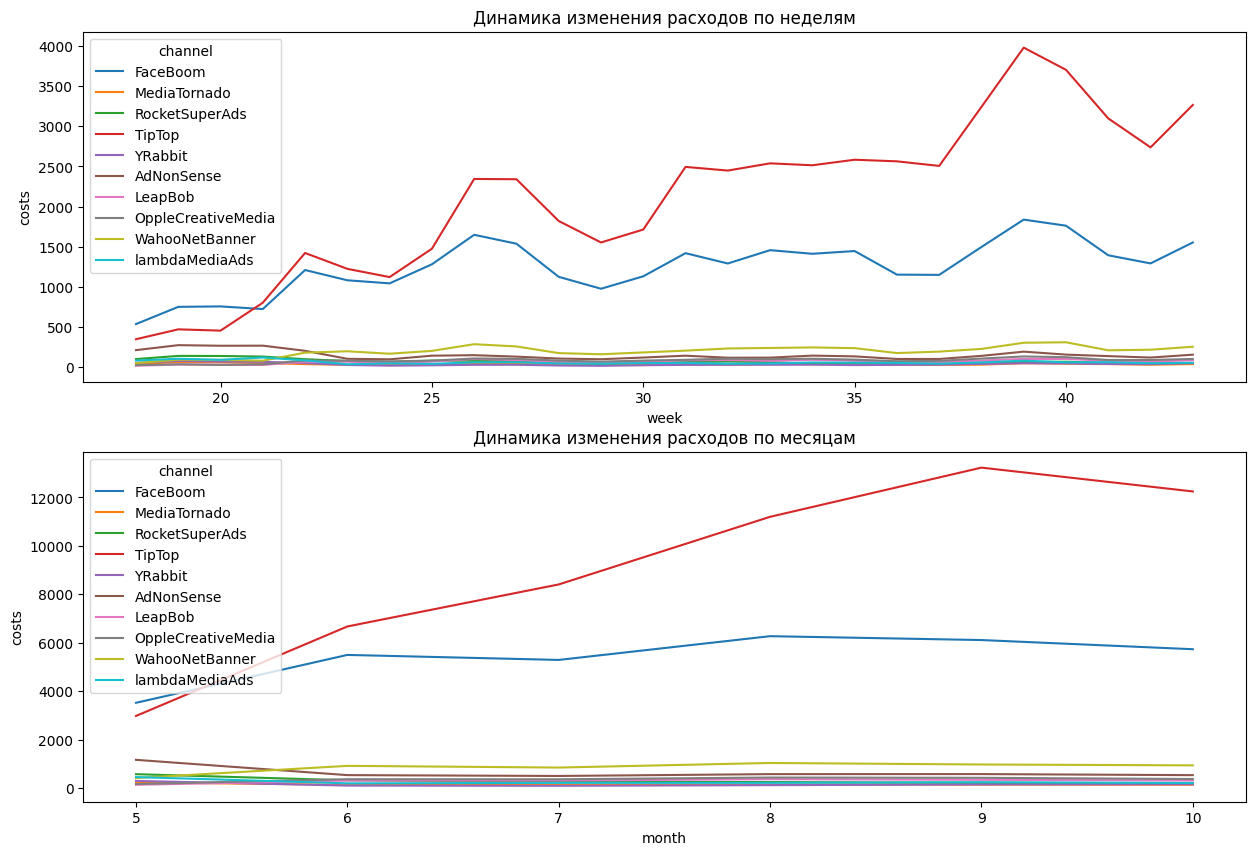

<Figure size 1500x500 with 0 Axes>

In [25]:
# строим графики

fig, axes = plt.subplots(2,1,figsize=(15,10), sharex=False)

sns.lineplot(x='week',
            y='costs',
            hue="channel",
            data=costs,
            estimator=np.sum,
            ci=None,
            ax=axes[0]
            ).set(title='Динамика изменения расходов по неделям')

plt.figure(figsize=(15,5))
sns.lineplot(x='month',
            y='costs',
            hue="channel",
            data=costs,
            estimator=np.sum,
            ci=None,
            ax=axes[1]
            ).set(title='Динамика изменения расходов по месяцам')


In [26]:
# Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Общая сумма расходов на рекламу с 1 мая по 27 октября 2019 года составила 105497.3 долларов (кстати, в задании не указаны единицы измерения; то, что это доллары, - предположение, но будем исходить из него).

Больше всего было потрачено на продвижение по этим трем каналам: TipTop	(54751.3), FaceBoom	(32445.6) и WahooNetBanner (5151).

На графике видно, что изначально лидером по вложениям в рекламу был канал FaceBoom, но очень быстро (примерно на 21й неделе) его обошел TipTop, который с тех пор оставался на первом месте. Также в начале на третьем месте был YRabbit, но примерно на 22-23й неделе его обошел WahooNetBanner. Дальше до конца исследуемого периода «расстановка сил» не менялась.

Самая высокая стоимость привлечения одного клиента - у канала TipTop (2,8 доллара), на втором месте с более чем двукратным отставанием - FaceBoom (1,1) и почти сразу за ним на третьем - AdNonSense (1 доллар).

<b> Промежуточный вывод: </b> 
    
TipTop и FaceBoom лидируют размеру рекламных бюджетов, но и САС у этих каналов самая высокая. При этом, как мы видели выше, эти каналы также принесли больше всего подписчиков. 

### Оценка окупаемости рекламы

#### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI

In [27]:
profiles = profiles.query('channel != "organic"') # исключаем пользователей с органическим трафиком

In [28]:
# считаем ltv и roi

result_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, horizon_days)

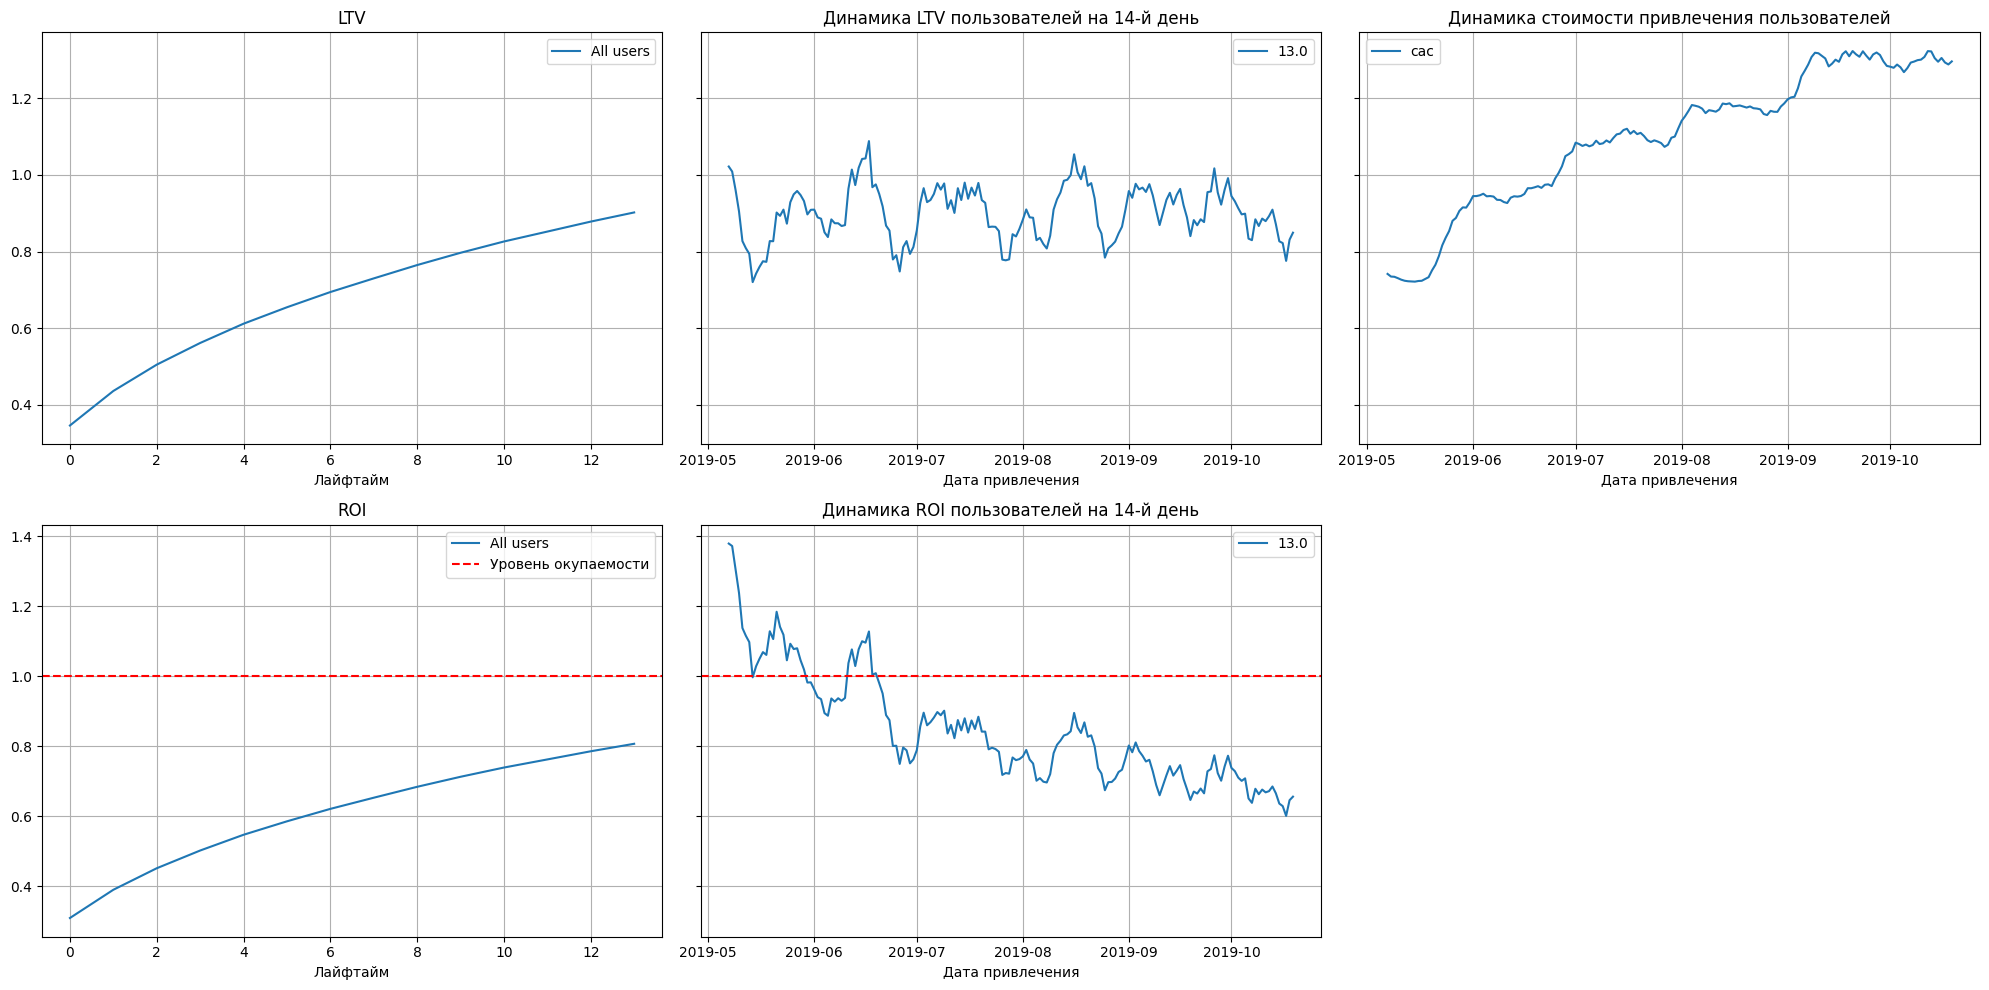

In [29]:
# строим графики

plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=7)

Выводы, которые мы можем сделать по графикам:

- Кривая LTV постоянно растёт ожидаемым образом. Значит, мы верно определили момент и горизонт анализа данных
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, компания терпит убытки не из-за ухудшения качества пользователей
- Стоимость привлечения пользователей с середины мая начала расти, значит, на рекламу стали тратить больше
- В конце мая реклама впервые не окупилась, затем в июне был период, когда она окупалась, но с середины июня и до конца наблюдений ROI стабильно ниже уровня окупаемости. В конце октября ROI на 14й день составил чуть больше 60%.


Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, устройству первого посещения и источнику.

#### Окупаемость рекламы с разбивкой по устройствам

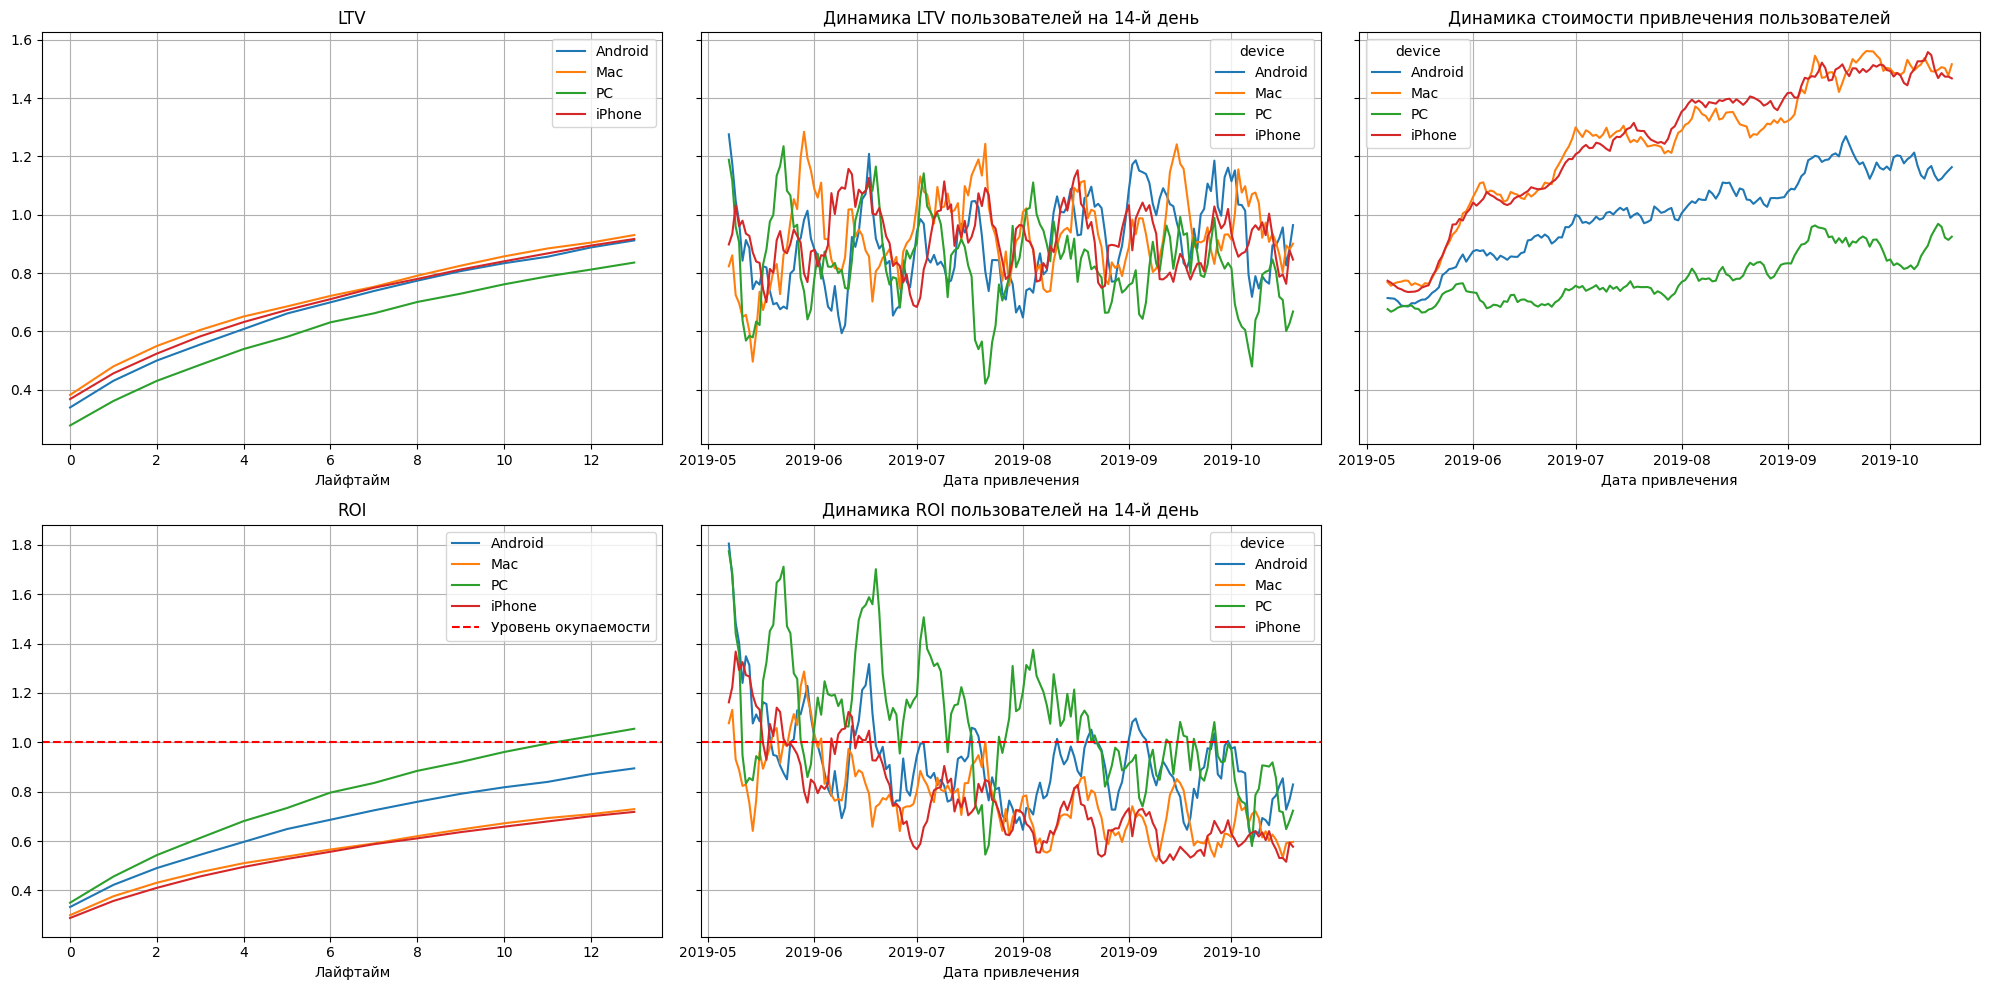

In [30]:
dimensions = ['device']

result_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=7)

Мы видим, что стоимость привлечения пользователей выросла одновременно для всех устройств, но не одинаково - САС для пользователей Мас и айфонов выросла значительно больше, меньше всего подорожало привлечение пользователей РС.

Из всех устройств окупается только ПК на 11й день, остальные не окупаются.

На графике динамики ROI мы видим, что в начале мая на 14й день окупались все пользователи, но очень быстро, все еще в мае, этот показатель резко ушел вниз. ROI пользователей всех устройств колебался, дольше всего в окупаемость выходил ПК, но к концу наблюдаемого периода и их окупаемость около 70%. ROI на 14й день для пользователей Мас и «айфонов» не поднимался выше уровня окупаемости с середины июля.

#### Окупаемость рекламы с разбивкой по странам

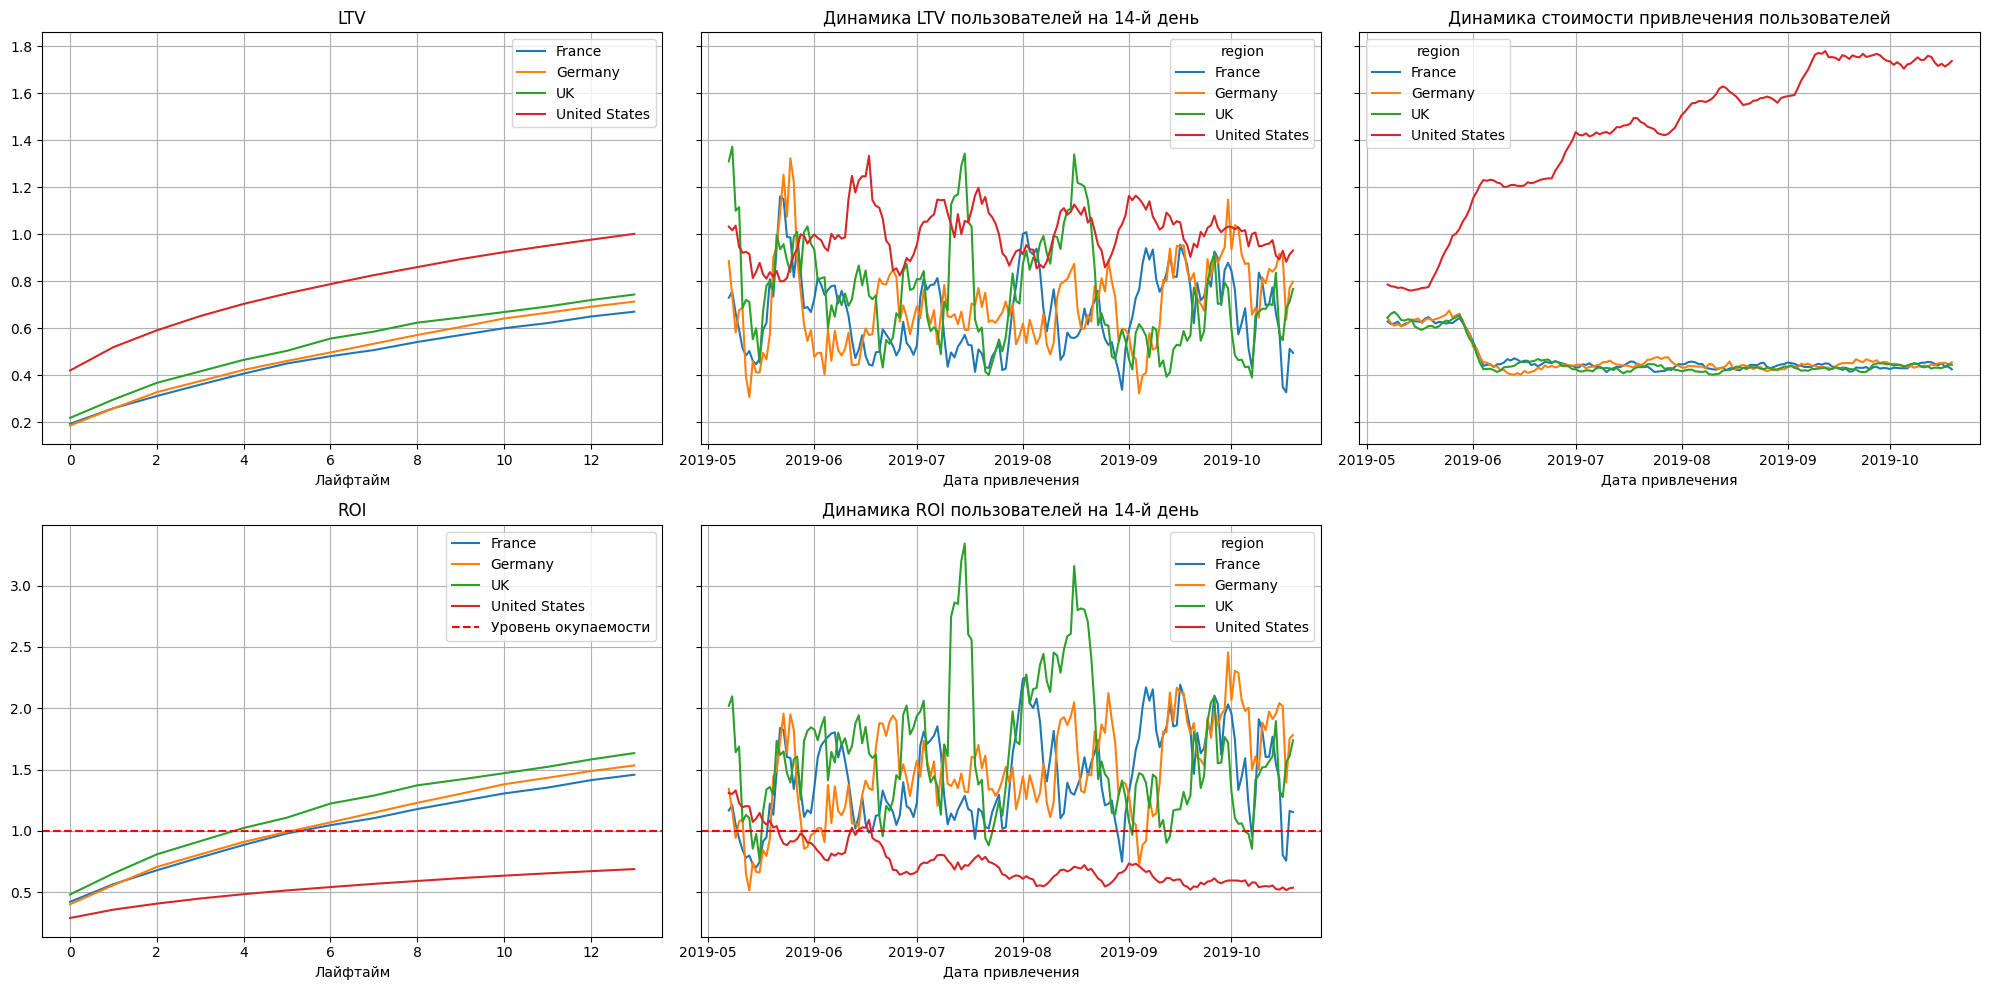

In [31]:
dimensions = ['region']

result_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=7)

Здесь мы отчетливо видим, какая страна «виновата» в убыточности рекламы - США. САС для пользователей других стран в июне даже снизился и затем оставался стабильным, а резкий скачок, который мы видели раньше, произошел только для пользователей из США. Графики ROI и динамики ROI на 14й день также показывают, что не окупается только привлечение пользователей из США.

#### Окупаемость рекламы с разбивкой по каналам привлечения

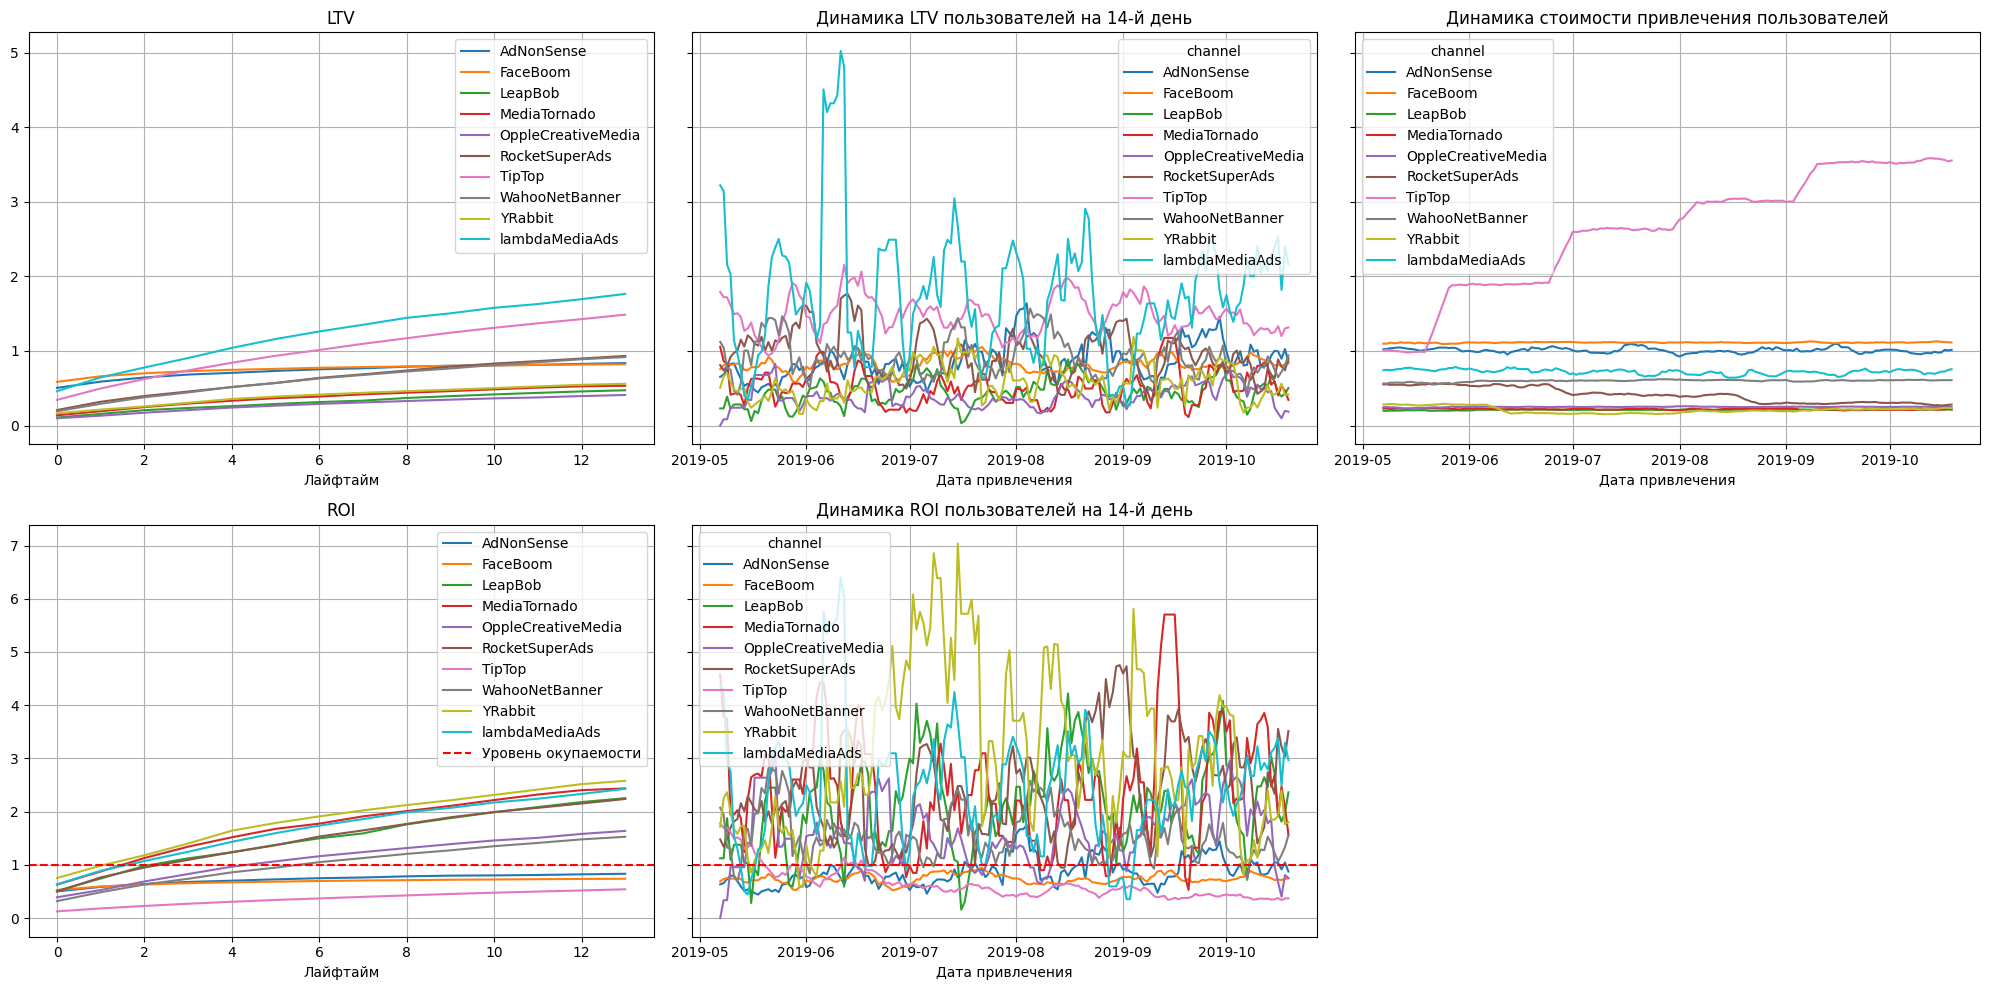

In [32]:
dimensions = ['channel']

result_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=7)

График динамики САС показывает, что резко подорожало привлечение пользователей через TipTop, САС по остальным каналам стабилен.

Не окупается привлечение пользователей через AdNonSense, FaceBoom и TipTop, остальные каналы окупаются. 

На графике динамики ROI на 14й день видно, что FaceBoom не окупался за весь период наблюдения никогда, TipTop перестал окупаться в середине мая, AdNonSense в конце октября вышел в точку окупаемости, но прибыли не приносит. Также ниже уровня окупаемости в конце октября опустился канал OppleCreativeMedia.






Из анализа выше мы помним, что пользователи из США - самая большая группа, их больше, чем всех остальных, вместе взятых. То есть больше всего привлекалось пользоватетей, чье привлечение значительно дороже остальных.

Кроме того, два канала, в продвижение через которые вкладывалось больше всего стредств, давно и стабильно не окупаются - это FaceBoom и TipTop.

Чтобы попытаться понять, в чем причина, изучим конверсию и удержание пользователей.

#### Конверсия и удержание пользователей и их динамика

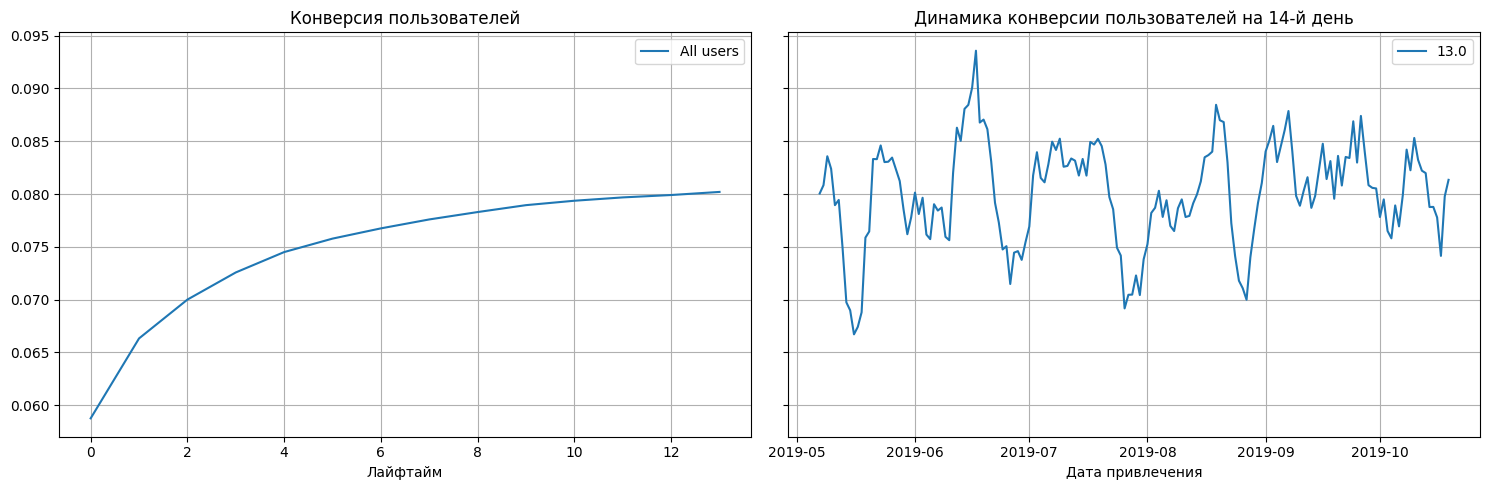

In [33]:
# смотрим конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, в конверсии хоть и есть колебания, но в целом она стабилна.

Выше мы видели, что не окупаются пользователи из США и пользователи «айфонов» и Мас. Посмотрим на конверсию по этим показателям отдельно.

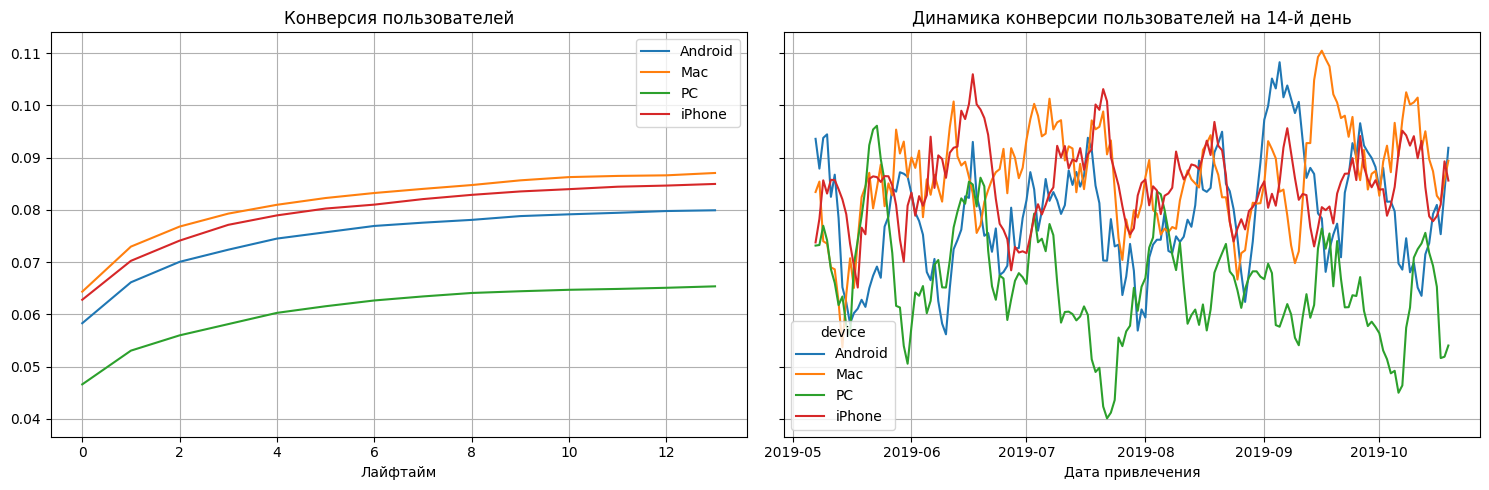

In [34]:
# смотрим конверсию по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

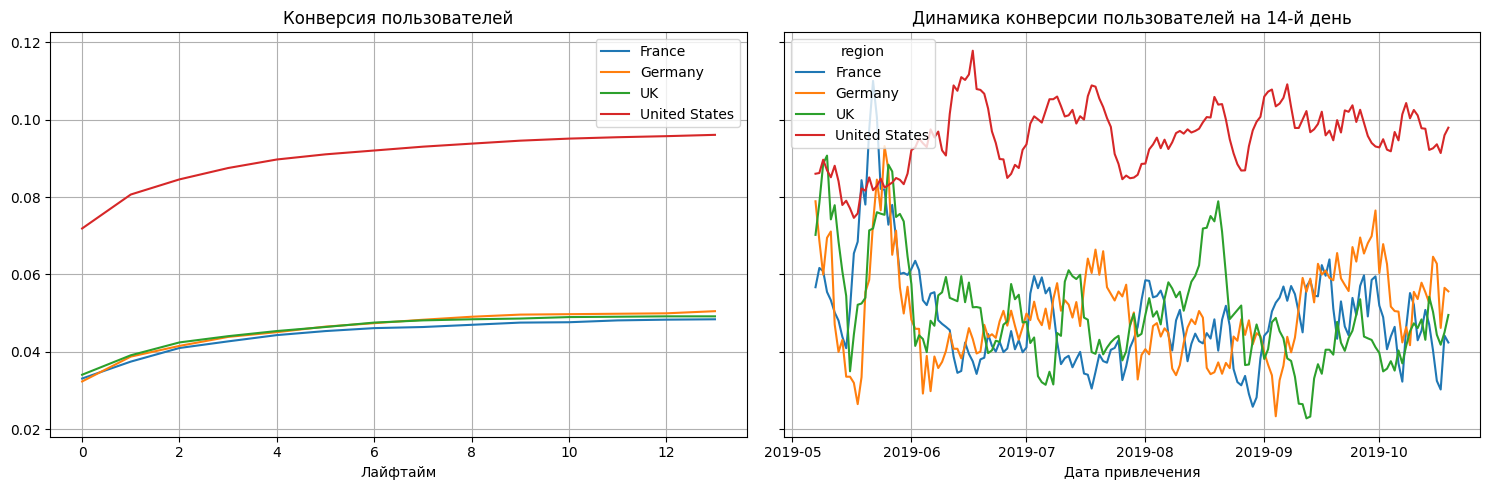

In [35]:
# смотрим конверсию по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Мы видим, что пользователи «айфонов» и Мас конвертируются лучше пользователей других устройств, и что пользователи из США с большим отрывом опережают пользователей других стран по конверсии.

Значит, дело не в конверсии, а, вероятно, в удержании. Проверим.

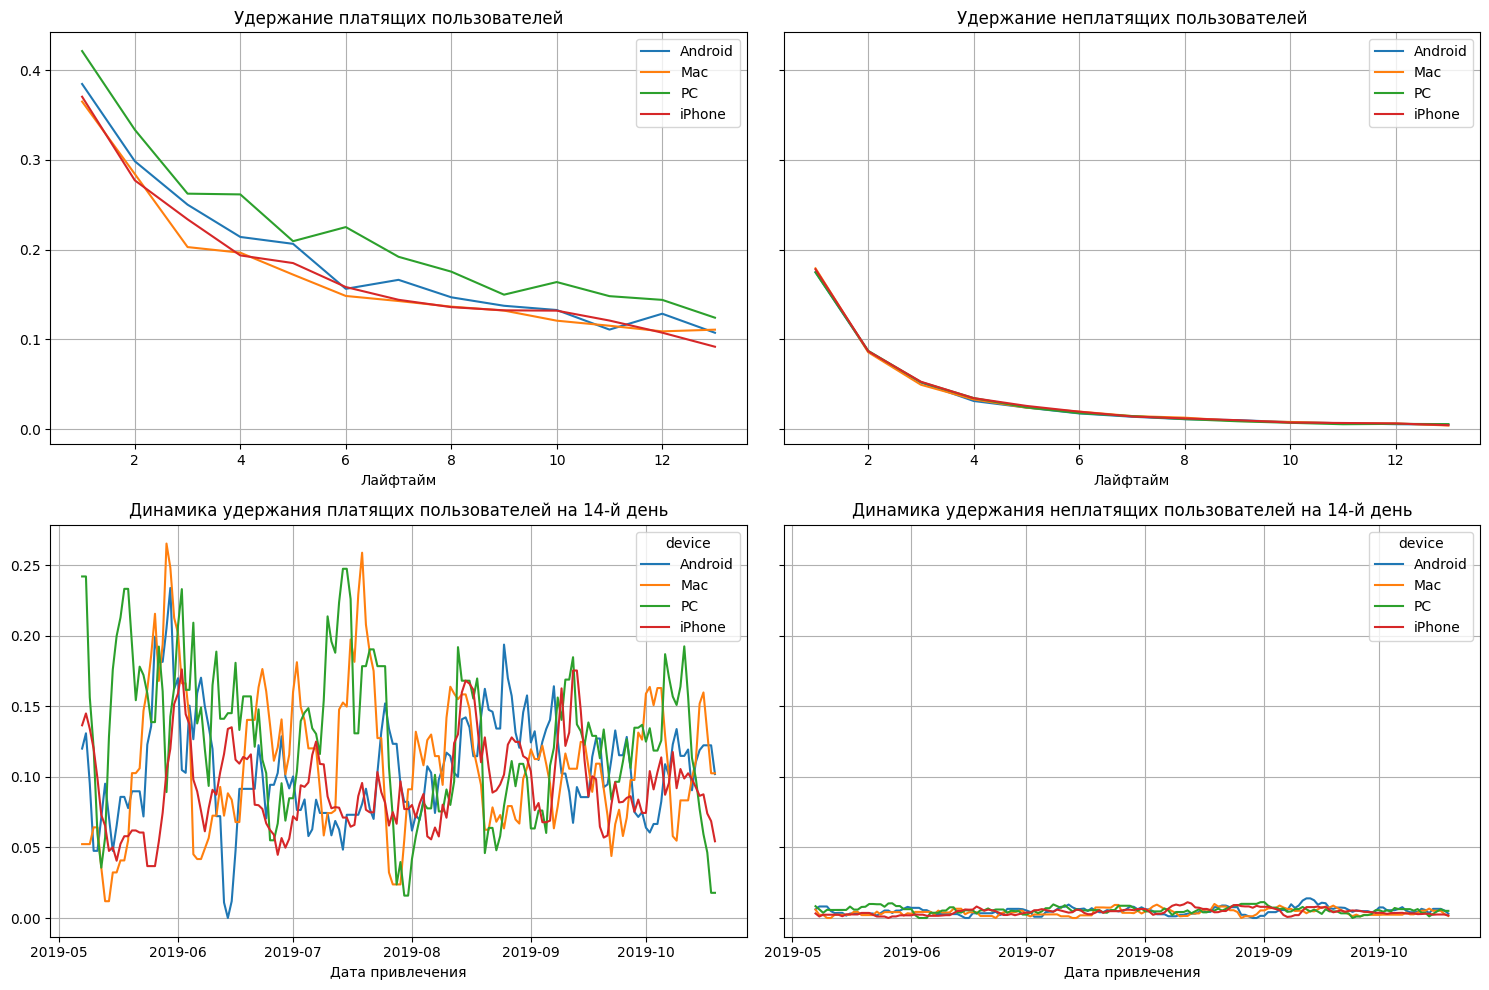

In [36]:
# смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Явной корреляции между удержанием и устройством мы не видим, пользователи любых устройств удерживаются плохо. На графике удержания видно, что хуже всех удерживаются пользователи «айфонов», но разница между ними и другими устройствами небольшая, до 5%. На графике динамики удержания на 14й день худшие показатели у пользователей ПК.

Раз большой разницы в удержании пользователей разных устройств нет, вероятно, проблема не техническая.

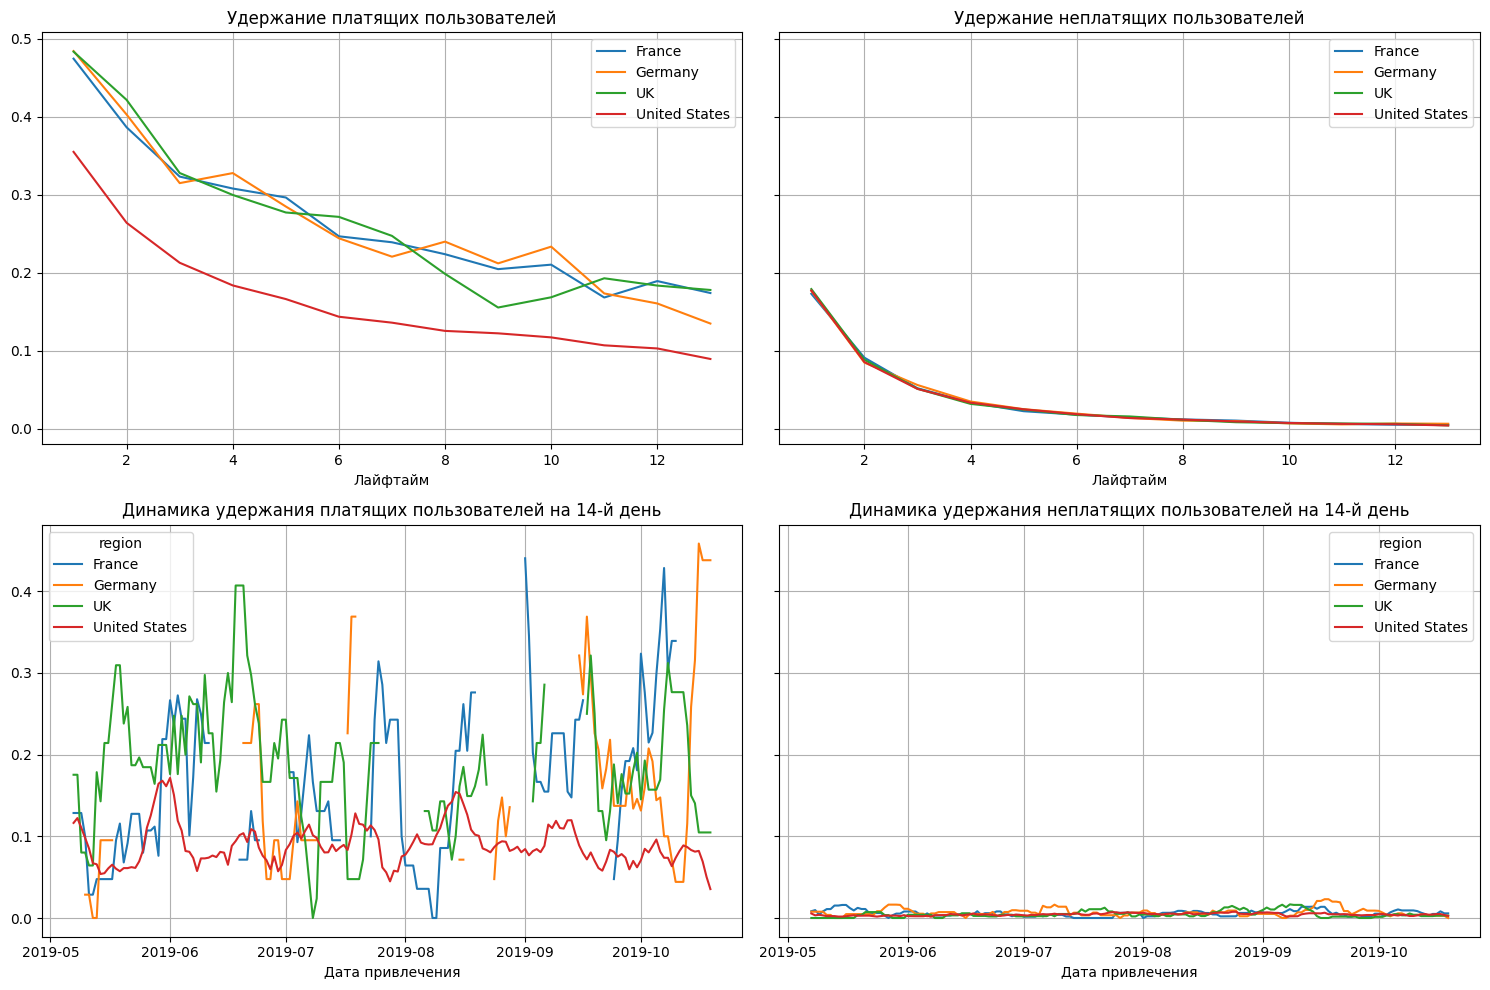

In [37]:
# смотрим удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот в разбивке по странам видно, что пользователи из США удерживаются значительно хуже остальных.

На протяжении всего рассматриваемого периода удержание пользователей из США колеблется в районе 10%.

На предыдущем графике мы видели, что пользователи «айфонов» и Мас удерживаются хуже пользователей других устройств. Посмотрим, не связано ли это с тем, что пользователи из США чаще пользуются «айфонами» и Мас.

In [38]:
profiles.groupby(by=['region','device']).agg({'user_id': 'nunique'})

user_id
region        device          
France        Android     3313
              Mac         1163
              PC          4384
              iPhone      2198
Germany       Android     2849
              Mac         1020
              PC          3797
              iPhone      1862
UK            Android     3243
              Mac         1086
              PC          4551
              iPhone      2274
United States Android    12436
              Mac        15424
              PC          6421
              iPhone     27548

Действительно, как мы видим, 75% пользователей из США пользуются либо «айфоном» либо Мас. Значит, скорее всего, плохое удержание связано с тем, из какой человек страны, а не с какого устройства он заходит в приложение.

Прежде чем переходить к выводам и давать рекомендации, проверим, из каких платных источников приходили пользователи каждой страны.

#### Дополнительная проверка

In [39]:
#разобьем профили пользователей по странам

usa = profiles.query('region == "United States"')
uk = profiles.query('region == "UK"')
germany = profiles.query('region == "Germany"')
france = profiles.query('region == "France"')

[Text(0.5, 1.0, 'Платные источники привлечения пользователей из Франции')]

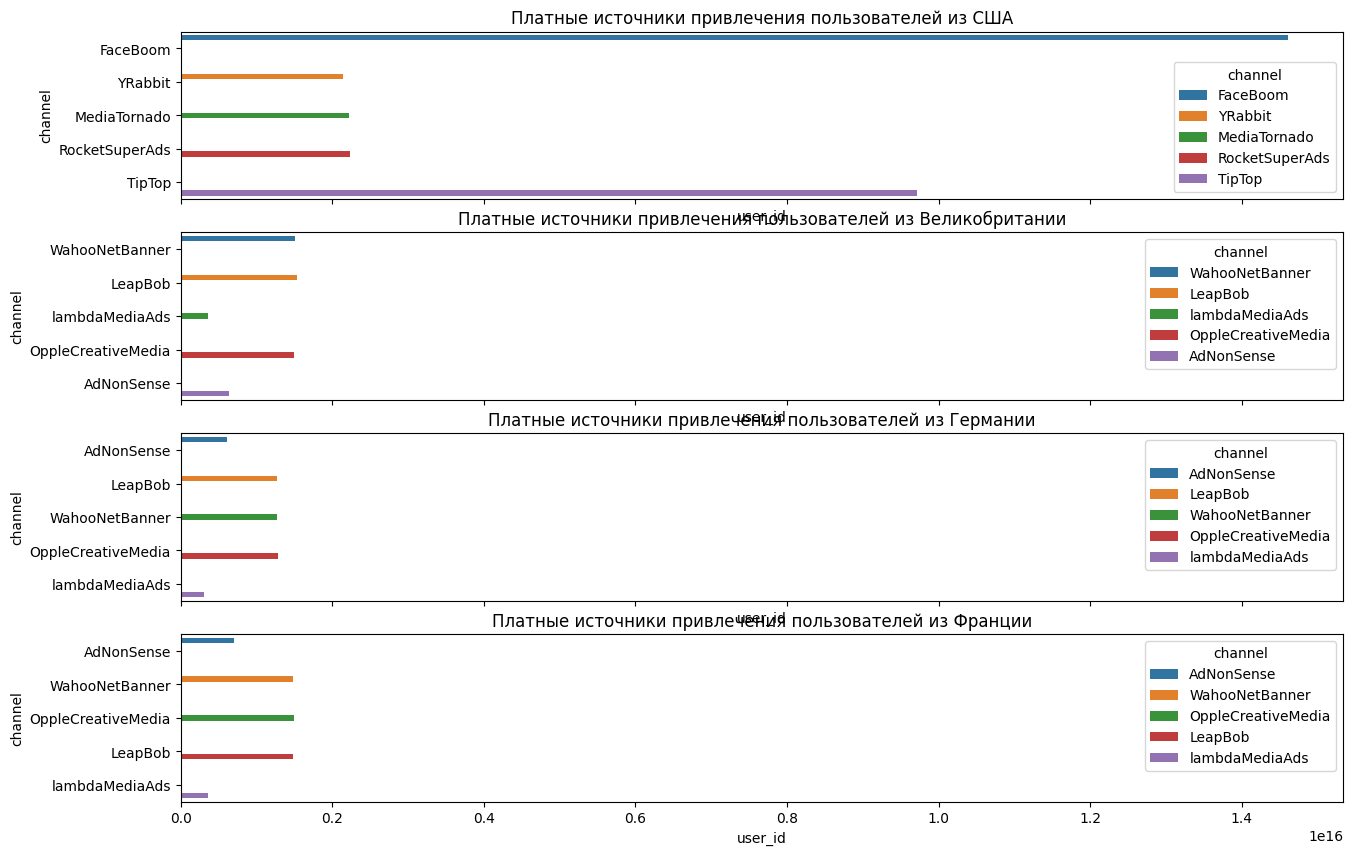

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [40]:
#посмотрим, из каких каналов пришли пользователи из каждой страны

fig, axes = plt.subplots(4,1,figsize=(15,10), sharex=True)

sns.barplot(x='user_id',
            y='channel',
            hue="channel",
            data=usa,
            estimator=np.sum,
            ci=None,
            ax=axes[0],
            ).set(title='Платные источники привлечения пользователей из США')

plt.figure(figsize=(15,5))
sns.barplot(x='user_id',
            y='channel',
            hue="channel",
            data=uk,
            estimator=np.sum,
            ci=None,
            ax=axes[1]
            ).set(title='Платные источники привлечения пользователей из Великобритании')

plt.figure(figsize=(15,5))
sns.barplot(x='user_id',
            y='channel',
            hue="channel",
            data=germany,
            estimator=np.sum,
            ci=None,
            ax=axes[2]
            ).set(title='Платные источники привлечения пользователей из Германии')

plt.figure(figsize=(15,5))
sns.barplot(x='user_id',
            y='channel',
            hue="channel",
            data=france,
            estimator=np.sum,
            ci=None,
            ax=axes[3]
            ).set(title='Платные источники привлечения пользователей из Франции')

Как показали графики, основные источники привлечения пользователей из США - FaceBoom и TipTop.
Основные источники привлечения пользователей из Великобритании, Германии и Франции одинаковы - WahooNetBanner, OppleCreativeMedia и LeapBob. FaceBoom и TipTop вообще не привлекают пользователей из этих стран.

Но, как мы помним, FaceBoom и TipTop - это те каналы, на продвижение через которые тратится больше всего средств, и у которых самый высокий САС. При этом, через эти каналы приходят только пользователи из США, которые удерживаются хуже всех остальных. То есть большая часть средств уходит на привлечение пользователей, которые быстро уходят и не окупаются. Поэтому компания и терпит убытки.

Чтобы исправить ситуацию, мы видим два сценария.

Первый. Ничего не менять в приложении, а сфокусироваться на привлечении пользователей не из США. В настоящее время доля пользователей из Британии, Франции и Германии значительно меньше, чем из США, но, вероятно, это произошло потому, что значительно больше средств направлялось на продвижение через FaceBoom и TipTop, откуда приходили только пользователи из США. Если сфокусироваться на другом канале, ситуация может измениться. У пользователей  из Британии, Франции и Германии хуже конверсия, но заметно лучше удержание. Кроме того, их САС значительно ниже: основные источники привлечения пользователей из Великобритании, Германии и Франции - WahooNetBanner (САС = 0,6) , OppleCreativeMedia (САС = 0,25) и LeapBob (САС = 0,21). (Для сравнения, у FaceBoom САС = 1,1, а у TipTop = 2,8.) Из этих трех источников лучшая конверсия у WahooNetBanner, поэтому в рамках этого сценария мы рекомендуем сконцентрироваться на этом канале для привлечения пользователей.

Второй. Поработать над удержанием пользователей из США, т.к. у них сейчас хорошая конверсия и высокий LTV. Мы проанализировали конверсию и удержание по устройствам и не выявили явной корреляции между плохим удержанием и тем, с какого устройства заходил пользователь. Поэтому, вероятно, пользователи уходят не из-за технических проблем. Скорее, им не нравится контент приложения. Но, чтобы выяснить, в чем конкретно проблема, необходим дополнительный анализ, опрос пользователей, работа с фокус-группами. Мы в данный момент не располагаем данными, чтобы дать более конкретные рекомендации в рамках того сценария.

Нам кажется, что для начала стоит попробовать первый подход, т.к. изменить маркетинговую стратегию быстрее и проще, чем контент приложения. Если привлечение других пользователей не поможет компании выйти в плюс, тогда уже переходить ко второму сценарию.


### Вывод

Мы проанализировали информацию о посещениях сайта с 1.05.19 по 27.10.19, заказах и расходах на рекламу и сделали следующие выводы.

Пользователи приложения пришли из 4х стран - США, Великобритании, Франции и Германии.
Больше половины всех пользователей пришли из США. У них высокий LTV и хорошая конверсия, но очень плохое удержание: в рассматривый период оно колеблется в районе 10%. 

Значительная часть пользователей из этой страны пришли из двух платных источников: FaceBoom и TipTop. У этих источников самый высокий САС: 1,1 и 2,8 долларов соотвественно, а на графике динамики ROI на 14й день видно, что FaceBoom не окупался за весь период наблюдения никогда, TipTop перестал окупаться в середине мая.

Реклама Procrastinate Pro+ перестала окупаться с середины июня - когда резко выросли вложения  в рекламу через FaceBoom и TipTop. Через эти каналы приходят только пользователи из США, которые удерживаются хуже всех остальных. То есть большая часть средств уходит на привлечение пользователей, которые быстро уходят и не окупаются. Поэтому компания и терпит убытки.


Чтобы исправить ситуацию, мы видим два сценария.

Первый. 

Ничего не менять в приложении, а сфокусироваться на привлечении пользователей не из США. У пользователей из Британии, Франции и Германии хуже конверсия, но заметно лучше удержание и ниже САС. 
Для их привлечения рекомендуем сфокусироваться на канале привлечения WahooNetBanner, у него относительно высокая конверсия и низкий САС. 

Второй. 

Поработать над удержанием пользователей из США, т.к. у них сейчас хорошая конверсия и высокий LTV. Мы проанализировали конверсию и удержание по устройствам и не выявили явной корреляции между плохим удержанием и тем, с какого устройства заходил пользователь. Поэтому, вероятно, пользователи уходят не из-за технических проблем. Скорее, им не нравится контент приложения. Чтобы выяснить, в чем конкретно проблема, необходим дополнительный анализ, опрос пользователей, работа с фокус-группами. 

Мы в данный момент не располагаем данными, чтобы дать более конкретные рекомендации в рамках того сценария.


Нам кажется, что для начала стоит попробовать первый подход, т.к. изменить маркетинговую стратегию быстрее и проще, чем контент приложения. Если привлечение других пользователей не поможет компании выйти в плюс, тогда уже переходить ко второму сценарию.
